In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem

import trieste
import gpflow
import tensorflow as tf

import numpy as np

from ik_loss import ik_loss_factory
from imp_var_with_ik import ImprovementVarianceWithIK

import typing

In [104]:
mol = Chem.MolFromSmiles('CC1CCCCCCCCC1')
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)

0

In [105]:
[cur.GetIdx() for cur in mol.GetAtomWithIdx(0).GetNeighbors()]

[1, 11, 12, 13]

In [106]:
def get_dihedral_angles(
    mol : Chem.rdchem.Mol
) -> typing.List[typing.Tuple[int]]:

    tmp_mol = Chem.RemoveHs(mol)
    
    dihedrals = []

    for bond in tmp_mol.GetBonds():
        u, v = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        u_neighbours = [atom.GetIdx() for atom in tmp_mol.GetAtomWithIdx(u).GetNeighbors() if atom.GetIdx() != v]
        v_neighbours = [atom.GetIdx() for atom in tmp_mol.GetAtomWithIdx(v).GetNeighbors() if atom.GetIdx() != u]

        for u_neighbour in u_neighbours:
            for v_neighbour in v_neighbours:
                dihedrals.append((u_neighbour, u, v, v_neighbour))

    return dihedrals          

In [107]:
search_space_dihedrals = get_dihedral_angles(mol)

In [108]:
ik_loss_dihedrals = []

In [109]:
from ik_loss import CyclicCollection

ring_atoms = []

for atom_idx in range(len(mol.GetAtoms())):
    if mol.GetAtomWithIdx(atom_idx).IsInRing():
        ring_atoms.append(atom_idx)
    
cyclic_ring_atoms = CyclicCollection(ring_atoms)

for i in range(len(cyclic_ring_atoms)):
        ik_loss_dihedrals.append(
            (
                cyclic_ring_atoms[i - 1] , 
                cyclic_ring_atoms[i], 
                cyclic_ring_atoms[i + 1], 
                cyclic_ring_atoms[i + 2]
            )
        )

In [110]:
ik_loss_dihedrals_idxs = []
for ring_dihedral in ik_loss_dihedrals:
    for i, dihedral in enumerate(search_space_dihedrals):
        if (dihedral == ring_dihedral) or (dihedral == ring_dihedral[::-1]):
            ik_loss_dihedrals_idxs.append(i)
            break

In [111]:
def get_energy(
    coords : typing.List[float],
    mol : Chem.rdchem.Mol = mol,
    dihedral_idxs : typing.List[typing.Tuple[int]] = search_space_dihedrals,
    return_mol : bool = False
) -> float:
    # Chem.MolToMolFile(Chem.RemoveHs(mol), 'tmp.mol')
    # tmp_mol = Chem.RWMol(Chem.AddHs(Chem.MolFromMolFile('tmp.mol')))

    
    Chem.MolToMolFile(mol, 'tmp.mol')
    tmp_mol = Chem.RWMol(Chem.MolFromMolFile('tmp.mol', removeHs=False))
    
    for (a, b, c, d), value in zip(dihedral_idxs, coords):
        bond_to_remove = None
        if tmp_mol.GetAtomWithIdx(b).IsInRing() and tmp_mol.GetAtomWithIdx(c).IsInRing():
            for bond in tmp_mol.GetBonds():
                u, v = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
                if (not tmp_mol.GetAtomWithIdx(u).IsInRing()) or (not tmp_mol.GetAtomWithIdx(v).IsInRing()):
                    continue
                if (u, v) not in {(a, b), (b, c), (c, d), (b, a), (c, b), (d, c)}:
                    bond_to_remove = (u, v)
                    break
            tmp_mol.RemoveBond(*bond_to_remove)
            Chem.FastFindRings(tmp_mol)
        # print(f"set dihedral {a, b, c, d} to {value}; Atoms: {(tmp_mol.GetAtomWithIdx(a).GetSymbol(), tmp_mol.GetAtomWithIdx(b).GetSymbol(), tmp_mol.GetAtomWithIdx(c).GetSymbol(), tmp_mol.GetAtomWithIdx(d).GetSymbol())}")
        Chem.rdMolTransforms.SetDihedralRad(tmp_mol.GetConformer(), a, b, c, d, value)
        if bond_to_remove is not None:
            tmp_mol.AddBond(*bond_to_remove)

    Chem.FastFindRings(tmp_mol)
    
    # AllChem.EmbedMolecule(tmp_mol)

    # print([Chem.rdMolTransforms.GetDihedralRad(tmp_mol.GetConformer(), *search_space_dihedrals[i]) for i in range(len(search_space_dihedrals))])
    
    mp = AllChem.MMFFGetMoleculeProperties(tmp_mol, mmffVariant='MMFF94')
    ff = AllChem.MMFFGetMoleculeForceField(tmp_mol, mp)
    for (a, b, c, d), value in zip(dihedral_idxs, coords):
        # ff.MMFFAddTorsionConstraint(a, b, c, d, False, 180*value/np.pi, 180*value/np.pi, 4e5)
        ff.MMFFAddTorsionConstraint(a, b, c, d, True, 0, 0, 4e5)
    ff.Minimize(maxIts=10000)

    print("Energy is ", ff.CalcEnergy())
    
    return ff.CalcEnergy()

In [112]:
def observer(
    x: tf.Tensor,
) -> tf.Tensor:
    return trieste.data.Dataset(
        query_points=x,
        observations=tf.map_fn(
            fn=lambda x: tf.constant(
                [
                    get_energy(x.numpy().tolist())
                ],
                dtype=tf.float64
            ),
            elems=x,
        )
    )

In [113]:
search_space = trieste.space.Box(
    [-np.pi for _ in range(len(search_space_dihedrals))],
    [np.pi for _ in range(len(search_space_dihedrals))]
)

In [118]:
num_initial_points = 5
initial_query_points = search_space.sample(num_initial_points)
initial_data = observer(initial_query_points)

initial_data += observer(
    tf.constant(
        [[Chem.rdMolTransforms.GetDihedralRad(mol.GetConformer(), *search_space_dihedrals[i]) for i in range(len(search_space_dihedrals))]],
        dtype=tf.float64
    )
)

gpflow_model = gpflow.models.GPR(
    initial_data.astuple(), 
    kernel=gpflow.kernels.Periodic(
        gpflow.kernels.RBF(
            variance=0.07,
            lengthscales=0.005,
            active_dims=[i for i in range(len(search_space_dihedrals))]
        ),
        period=[2*np.pi for _ in range(len(search_space_dihedrals))]
    ),
    noise_variance=1e-5
)
gpflow.set_trainable(gpflow_model.likelihood, False)

model = trieste.models.gpflow.GaussianProcessRegression(gpflow_model)

Energy is  188132.75157670482
Energy is  1393.4331633017762
Energy is  40468.095052179706
Energy is  8606.652093111667
Energy is  561578.2159456348
Energy is  61.365719239976066


In [119]:
ask_tell = trieste.ask_tell_optimization.AskTellOptimizer(
    search_space=search_space, 
    datasets=initial_data, 
    models=model,
    acquisition_rule=trieste.acquisition.rule.EfficientGlobalOptimization(
        ImprovementVarianceWithIK(
            threshold=3.,
            ik_loss=configure_ik_loss(mol),
            ik_loss_idxs=ik_loss_dihedrals_idxs,
            ik_loss_weight=10.
        )
    )
)

In [ ]:
import timeit

for step in range(100):
    start = timeit.default_timer()
    new_point = ask_tell.ask()
    stop = timeit.default_timer()

    print(f"Time at step {step + 1}: {stop - start}; Deepest minima: {tf.reduce_min(ask_tell.dataset.observations).numpy()}")

    new_data = observer(new_point)
    ask_tell.tell(new_data)

Tensor("Shape_10:0", shape=(2,), dtype=int32)
Tensor("Shape_10:0", shape=(2,), dtype=int32)
Time at step 1: 15.024902871999075; Deepest minima: 61.365719239976066
Energy is  37102.62378573242
Time at step 2: 12.071813331989688; Deepest minima: 61.365719239976066
Energy is  121492.70485697551
Time at step 3: 12.355717840007856; Deepest minima: 61.365719239976066
Energy is  201010.65905426658
Time at step 4: 12.477719668997452; Deepest minima: 61.365719239976066
Energy is  1116987.8200419198
Time at step 5: 12.68532119000156; Deepest minima: 61.365719239976066
Energy is  1730.0228931632134
Time at step 6: 13.102041309000924; Deepest minima: 61.365719239976066
Energy is  11402.339278819392
Time at step 7: 11.617149704004987; Deepest minima: 61.365719239976066
Energy is  320089.8424876713
Time at step 8: 11.275821219998761; Deepest minima: 61.365719239976066
Energy is  69266.54677826415
Time at step 9: 11.984894050008734; Deepest minima: 61.365719239976066
Energy is  1036.7546973116253
Tim

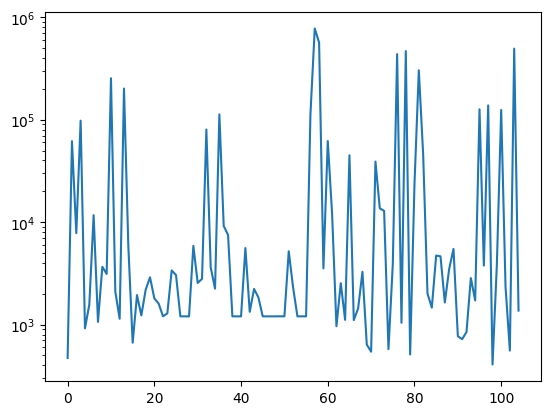

In [99]:
import matplotlib.pyplot as plt
plt.plot(
    ask_tell.dataset.observations.numpy().flatten()
)
plt.yscale('log')

In [58]:
def configure_mol(
    coords : typing.List[float],
    mol : Chem.rdchem.Mol = mol,
    dihedral_idxs : typing.List[typing.Tuple[int]] = search_space_dihedrals,
) -> float:
    Chem.MolToMolFile(mol, 'tmp.mol')
    tmp_mol = Chem.RWMol(Chem.MolFromMolFile('tmp.mol', removeHs=False))
    
    for (a, b, c, d), value in zip(dihedral_idxs, coords):
        bond_to_remove = None
        if tmp_mol.GetAtomWithIdx(b).IsInRing() and tmp_mol.GetAtomWithIdx(c).IsInRing():
            for bond in tmp_mol.GetBonds():
                u, v = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
                if (not tmp_mol.GetAtomWithIdx(u).IsInRing()) or (not tmp_mol.GetAtomWithIdx(v).IsInRing()):
                    continue
                if (u, v) not in {(a, b), (b, c), (c, d), (b, a), (c, b), (d, c)}:
                    bond_to_remove = (u, v)
                    break
            tmp_mol.RemoveBond(*bond_to_remove)
            Chem.FastFindRings(tmp_mol)
        Chem.rdMolTransforms.SetDihedralRad(tmp_mol.GetConformer(), a, b, c, d, value)
        if bond_to_remove is not None:
            tmp_mol.AddBond(*bond_to_remove)

    Chem.FastFindRings(tmp_mol)

    return tmp_mol#Chem.AddHs(tmp_mol)

In [61]:
print(
    Chem.MolToXYZBlock(
        Chem.RemoveHs(
            configure_mol(
                tf.gather(
                    ask_tell.dataset.query_points,
                    tf.argmin(ask_tell.dataset.observations),
                    axis=0
                ).numpy().flatten()
            )
        )
    )
)

7

C      2.467514    0.290635    0.142937
C      0.993998    0.371044   -0.116874
C      0.527778   -0.928225   -0.758128
C      1.168249   -1.564753    1.275006
C     -0.146986   -1.847932    1.492993
C     -1.290481    1.149308    0.475719
C      0.199498    0.760959    1.092169

